## Importing segmentations

This notebook shows how to import segmentation data to the Eyened database.

In [1]:
import io
import json

import numpy as np
import requests
from matplotlib import pyplot as plt


def get_buffer(data: np.ndarray):
    buffer = io.BytesIO()
    np.save(buffer, data)
    buffer.seek(0)
    return buffer

In [2]:
api_url = 'http://eyened-gpu:16001/api/'

## Segmentations @ eyened-orm

The segmentations in Eyened ORM follow a few rules:

- All segmentations are attached to a single image instance
- All segmentations have shape (D, H, W)
- the Depth, Height, Width columns of the Segmentation object must always match the shape of the stored numpy array data and should not be updated
- Segmentations shape and parameteres defines how the annotation is matched to the image volume.

By default segmentation.shape == image.shape. That is:
- Segmentation.Depth == ImageInstance.NrOfFrames or 1 
- Segmentation.Height == ImageInstance.Rows_y
- Segmentation.Width == ImageInstance.Columns_x
However, if ImageProjectionMatrix is provided, two dimensions may differ. SparseAxis must indicate the dimension that is not modified (0=Depth, 1=Height, 2=Width)

SliceIndices is used to indicate which slices along SparseAxis have valid data (e.g. when annotating a subset of B-scans in an OCT volume).

Along SparseAxis, the segmentation shape must be equal to the image shape, or it must be 1 (this is used for 2D on 3D annotations not associated with a slice, e.g. enface-projection)


### examples of valid annotation shapes

**2D color fundus**
 - image shape: [1, 1632, 2464]
 - annotation shape: [1, 1632, 2464]
 - SparseAxis: 0
 - ScanIndices: NULL
 - ImageProjectionMatrix: NULL

**2D color fundus, with transformation matrix**
 - image shape: [1, 1632, 2464]
 - annotation shape: [1, 1024, 1024]
 - SparseAxis: 0
 - ScanIndices: NULL
 - ImageProjectionMatrix: [[0.6, 0, 100], [0, 0.6, 100], [0, 0, 1]]


**3D OCT, sparse B-scans**
 - image shape: [128, 885, 512]
 - annotation shape: [128, 885, 512]
 - SparseAxis: 0
 - ScanIndices: [54, 62, 81]
 - ImageProjectionMatrix: NULL

 
**3D OCT, full volume**
 - image shape: [128, 885, 512]
 - annotation shape: [128, 885, 512]
 - SparseAxis: 0
 - ScanIndices: NULL
 - ImageProjectionMatrix: NULL


**3D OCT, enface projection**
 - image shape: [128, 885, 512]
 - annotation shape: [128, 1, 512]
 - SparseAxis: 1
 - ScanIndices: NULL
 - ImageProjectionMatrix: NULL

## Working with annotations

- Annotations can be created by providing database columns and numpy arrays satisfying the constraints above.
- After an annotation is created it can only be replaced with an annotation of the same shape. This is intentional to encourage consistency.

## New annotation with metadata

In [3]:
# Create a sample numpy array
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.uint8)[None, ...]
depth, height, width = data.shape

# Serialize numpy array to bytes
buffer = get_buffer(data)

metadata = {
    'ImageInstanceID': 331115, # CFI image
    'FeatureID': 43,
    'DataRepresentation': 'DualBitMask',
    'DataType': 'R8UI',
    'Threshold': 0,
    'SparseAxis': 0,
    'CreatorID': 1,
    
    'Depth': depth,
    'Height': height,
    'Width': width,
    
    'ImageProjectionMatrix': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
}

files = {
    'np_array': ('data.npy', buffer.read(), 'application/octet-stream'),
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
resp = requests.post(
    api_url + f'segmentations',
    files=files
)

In [4]:
resp.text

'{"ImageInstanceID":331115,"DataRepresentation":"DualBitMask","DateModified":null,"ZarrArrayIndex":0,"DataType":"R8UI","Inactive":false,"Depth":1,"Threshold":0.0,"Height":3,"ReferenceSegmentationID":null,"Width":3,"SegmentationID":54,"SparseAxis":0,"CreatorID":1,"ImageProjectionMatrix":[[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]],"FeatureID":43,"ScanIndices":null,"DateInserted":"2025-07-21T12:50:17"}'

In [5]:
response = resp.json()
segmentation_id = response["SegmentationID"]

In [6]:
response

{'ImageInstanceID': 331115,
 'DataRepresentation': 'DualBitMask',
 'DateModified': None,
 'ZarrArrayIndex': 0,
 'DataType': 'R8UI',
 'Inactive': False,
 'Depth': 1,
 'Threshold': 0.0,
 'Height': 3,
 'ReferenceSegmentationID': None,
 'Width': 3,
 'SegmentationID': 54,
 'SparseAxis': 0,
 'CreatorID': 1,
 'ImageProjectionMatrix': [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
 'FeatureID': 43,
 'ScanIndices': None,
 'DateInserted': '2025-07-21T12:50:17'}

## Reading the segmentation data

In [7]:
response = requests.get(
    api_url + f'segmentations/{segmentation_id}/data',
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)

In [8]:
np_array.shape

(1, 3, 3)

In [9]:
np_array

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]], dtype=uint8)

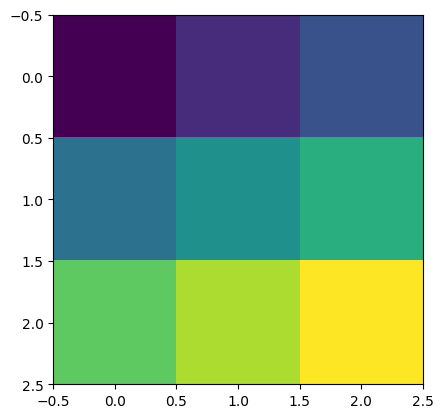

In [10]:
plt.imshow(np_array[0])

## Replacing segmentation data

In [11]:
# Update segmentation data using PUT request
# Create a modified numpy array (different from the original)
updated_data = np.array([[9, 8, 7], [6, 5, 4], [3, 2, 1]], dtype=np.uint8)[None, ...]

buffer = get_buffer(updated_data)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{segmentation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'}
)
response.json()

{'ImageInstanceID': 331115,
 'DataRepresentation': 'DualBitMask',
 'DateModified': None,
 'ZarrArrayIndex': 0,
 'DataType': 'R8UI',
 'Inactive': False,
 'Depth': 1,
 'Threshold': 0.0,
 'Height': 3,
 'ReferenceSegmentationID': None,
 'Width': 3,
 'SegmentationID': 54,
 'SparseAxis': 0,
 'CreatorID': 1,
 'ImageProjectionMatrix': [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
 'FeatureID': 43,
 'ScanIndices': None,
 'DateInserted': '2025-07-21T12:50:17'}

In [12]:
response = requests.get(
    api_url + f'segmentations/{segmentation_id}/data'
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)

[[[9 8 7]
  [6 5 4]
  [3 2 1]]]


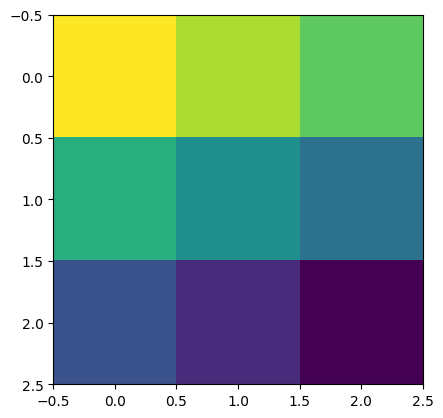

In [13]:
print(np_array)
plt.imshow(np_array[0])

## replacing with different shape (error)

In [14]:
# Update segmentation data using PUT request
# Create a modified numpy array (different from the original)
updated_data = np.array([[9, 8, 7], [6, 5, 4], [3, 2, 1], [0, 0, 0]], dtype=np.uint8)[...,None]

# Serialize numpy array to bytes
buffer = io.BytesIO()
np.save(buffer, updated_data)
buffer.seek(0)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{segmentation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'}
).json()

In [15]:
response

{'detail': 'Expected spatial dimensions (1, 3, 3), got (4, 3, 1)'}

## OCT Volume Annotation

In [16]:
## New empty annotation
metadata = {
    'ImageInstanceID': 331116, # OCT image
    'FeatureID': 11,   
    'CreatorID': 1,
    'DataType': 'R8UI',
    'DataRepresentation': 'MultiClass',
}

files = {
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
response = requests.post(
    api_url + f'segmentations',
    files=files
)

In [17]:
segmentation = response.json()
segmentation_id = segmentation['SegmentationID']

## write single slice

In [18]:
new_slice = np.random.randint(0, 255, (segmentation['Height'], segmentation['Width']), dtype=np.uint8)
new_slice[300:350,...] = 255

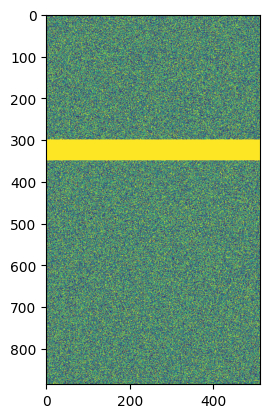

In [19]:
plt.imshow(new_slice)

In [20]:
buffer = get_buffer(new_slice)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{segmentation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'},
    params={'axis': 0, 'scan_nr': 34}
)

response.json()

{'ImageInstanceID': 331116,
 'DataRepresentation': 'MultiClass',
 'DateModified': None,
 'ZarrArrayIndex': 0,
 'DataType': 'R8UI',
 'Inactive': False,
 'Depth': 128,
 'Threshold': 0.5,
 'Height': 885,
 'ReferenceSegmentationID': None,
 'Width': 512,
 'SegmentationID': 55,
 'SparseAxis': None,
 'CreatorID': 1,
 'ImageProjectionMatrix': None,
 'FeatureID': 11,
 'ScanIndices': None,
 'DateInserted': '2025-07-21T12:50:36'}

In [21]:
response

<Response [200]>

# read single slices

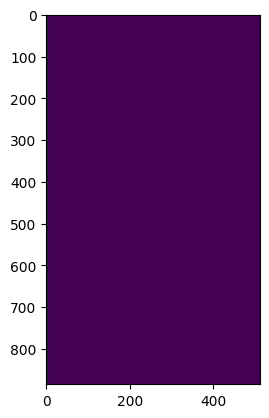

In [22]:
response = requests.get(
    api_url + f'segmentations/{segmentation_id}/data',
    params={'axis': 0, 'scan_nr': 33}
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)
plt.imshow(np_array)

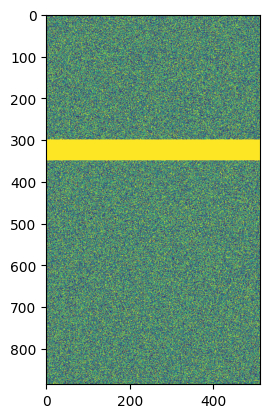

In [23]:
response = requests.get(
    api_url + f'segmentations/{segmentation_id}/data',
    params={'axis': 0, 'scan_nr': 34}
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)
plt.imshow(np_array)

## Sparse Volume

In [24]:
## New empty annotation
metadata = {
    'ImageInstanceID': 331116, # OCT image
    'FeatureID': 11,   
    'CreatorID': 1,
    'DataType': 'R8UI',
    'DataRepresentation': 'MultiClass',
    'SparseAxis': 0,
    'ScanIndices': [] # empty list for now
}

files = {
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
response = requests.post(
    api_url + f'segmentations',
    files=files
)
segmentation = response.json()
segmentation_id = segmentation['SegmentationID']
segmentation_id

56

In [25]:
segmentation = requests.get(api_url + f"segmentations/{segmentation_id}").json()
response = requests.get(api_url + f"segmentations/{segmentation_id}/data")
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)
print(np_array.shape, segmentation['ScanIndices'])

(128, 885, 512) []


In [30]:
# add some slices to the sparse volume
new_slice = np.ones((segmentation['Height'], segmentation['Width']), dtype=np.uint8)


for slice_nr in [1, 5, 6, 43, 10000, -1]:
    buffer = get_buffer(new_slice)
    response = requests.put(
        api_url + f'segmentations/{segmentation_id}/data',
        data=buffer.read(),
        headers={'Content-Type': 'application/octet-stream'},
        params={'axis': 0, 'scan_nr': slice_nr}
    )
    print(slice_nr, response.status_code, response.json())

1 200 {'DataRepresentation': 'MultiClass', 'DateModified': None, 'ZarrArrayIndex': 1, 'DataType': 'R8UI', 'Inactive': False, 'Depth': 128, 'Threshold': 0.5, 'Height': 885, 'ReferenceSegmentationID': None, 'Width': 512, 'SegmentationID': 56, 'SparseAxis': 0, 'CreatorID': 1, 'ImageProjectionMatrix': None, 'FeatureID': 11, 'ImageInstanceID': 331116, 'ScanIndices': [1], 'DateInserted': '2025-07-21T12:50:49'}
5 200 {'DataRepresentation': 'MultiClass', 'DateModified': None, 'ZarrArrayIndex': 1, 'DataType': 'R8UI', 'Inactive': False, 'Depth': 128, 'Threshold': 0.5, 'Height': 885, 'ReferenceSegmentationID': None, 'Width': 512, 'SegmentationID': 56, 'SparseAxis': 0, 'CreatorID': 1, 'ImageProjectionMatrix': None, 'FeatureID': 11, 'ImageInstanceID': 331116, 'ScanIndices': [1, 5], 'DateInserted': '2025-07-21T12:50:49'}
6 200 {'DataRepresentation': 'MultiClass', 'DateModified': None, 'ZarrArrayIndex': 1, 'DataType': 'R8UI', 'Inactive': False, 'Depth': 128, 'Threshold': 0.5, 'Height': 885, 'Referenc

In [31]:
segmentation = requests.get(api_url + f"segmentations/{segmentation_id}").json()
segmentation['ScanIndices']

[1, 5, 6, 43]

## Overview of stored annotations

- Zarr arrays are stored in groups. Each group maps to one SegmentationType
- Within each group, arrays are identified by `<dtype>_<height>_<width>_<depth>` of the segmentation.

In [32]:
!eorm zarr-tree --env test

Zarr store: /home/bart/25/eyened_platform/storage.zarr

Group: DataRepresentation.DualBitMask
------------------------------
  Array: uint8_1_3_3.zarr
    Shape: (1, 1, 3, 3)
    Dtype: uint8
    Chunks: (1, 1, 3, 3)

Group: DataRepresentation.MultiClass
------------------------------
  Array: uint8_128_885_512.zarr
    Shape: (2, 128, 885, 512)
    Dtype: uint8
    Chunks: (1, 128, 885, 512)
